In [81]:
#imports
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [48]:
#declare file path variables here
rl_f = os.path.abspath('../../../results/pat0_t1/rl.txt')
irl_f = os.path.abspath('../../../results/pat0_t1/irl.txt')#(iter, traj#, timestep, x[0], x[1], action (or S))

In [72]:
#gets values for plotting
#reward values change over time
def reward_var(file_name):
    rtn = []
    with open(file_name, 'r') as file:
        for line in file.read().split('_'):
            w = line.split('tensor')[-1][:-1]#removes the final ")"
            rtn.append([int(a) for a in w.split(', ')])
    return rtn


In [73]:

reward_var(irl_f)

1
1
1
1


In [57]:
#returns list, percentage of time in range for each iteration
def time_in_range(f_name, low, high):
    iters = -1
    total = 0
    rtn = []
    with open(f_name, 'r') as file:
        for line in file:
            curr_i, glucose = int(line.split(",")[0]), float(line.split(",")[3])
            if curr_i == iters:
                rtn[-1] += low <= glucose <= high
                total +=1
            else:
                if iters != -1:
                    rtn[-1] = rtn[-1]/total
                iters +=1
                total = 1
                rtn.append(low<= glucose <= high)
        rtn[-1] = rtn[-1]/total
    return rtn

In [62]:
tst = time_in_range(rl_f, -0.65, -0.6)

In [63]:
tst

[0.3235294117647059]

In [74]:

def avg_glucose_reward(fpath_rl, fpath_irl, iters):
    ret = [] #list of (x, y) for each iteration to be plotted
    res_from_file = dict() #stores results from file
    reward_vals = dict()
    WINDOW_SIZE = 12

    #getting data from the rl_file
    with open(fpath_rl) as f_rl:
        for rl_line in f_rl:
            rl_iter = int(rl_line.split(", ")[0]) #irl iter of line in rl file
            if rl_iter in iters: #want to plot
                if rl_iter in res_from_file.keys():
                    res_from_file[rl_iter].append(float(rl_line.split(", ")[3]))
                else:
                    res_from_file[rl_iter] =[float(rl_line.split(", ")[3])]
    
    #getting data from the irl file
    with open(fpath_irl) as f_irl:
        lines = f_irl.read().split("_")[1:]
        for line in lines:
            rl_iter = int(line.split(", ")[0])
            if rl_iter in iters:#want to plot 
                reward_vals[rl_iter] = eval("torch." + (", ".join(line.split(",")[13:-1]))) #doesnt work for iteration 0
                
    
    #now we have the data, time to get what is to be plotted
    for iter in iters:
        x = []
        y = []
        w = reward_vals[iter]
        g_vals = np.array(res_from_file[iter])
        n = len(g_vals)
        for i in range(n - WINDOW_SIZE): #+1?
            curr_g = g_vals[i:i+WINDOW_SIZE]
            x.append(np.average(curr_g))
            y.append(np.tensordot(curr_g, w, 1))
        ret.append((x, y))
    
    return ret





In [79]:
a = avg_glucose_reward(rl_f, irl_f, [200])
print(len(a[0][1]))

60


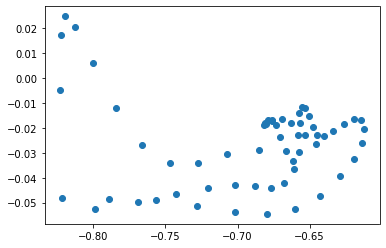

In [83]:
plt.scatter(a[0][0], a[0][1])